In [1]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

In [2]:
#sc_out = pd.DataFrame()
#for file in os.listdir('../ce_data/StatCache'):
#    x = pd.read_csv("../ce_data/StatCache/"+file)
#    x['id'] = x.index
#    x['id'] = x['id'].apply(lambda x: file[:-4] + "_" + str(x))
#    sc_out = pd.concat([x, sc_out], ignore_index=True)
#sc_out = sc_out.sort_values("id", ascending=True, ignore_index=True).fillna(0)
sc_out = pd.read_csv('../ce_data/output_512/statcache_512_lb.csv')
for i in ['1024','2048','4096','8192']:
    sc_out['lru_'+i] = sc_out['lru_'+i]/sc_out['total_accesses']
sc_out['lru_512'] = sc_out['lru_512']/sc_out['total_accesses_512']
print(sc_out)

                         id  random_512   lru_512  total_accesses_512  \
0       400.perlbench-41B_0    1.000000  1.000000              571328   
1     400.perlbench-41B_436    0.999808  1.000000              840656   
2       400.perlbench-50B_0    1.000000  1.000000              640304   
3          401.bzip2-226B_0    0.979854  1.000000             1095856   
4         401.bzip2-226B_54    0.926886  0.988926             1155840   
...                     ...         ...       ...                 ...   
6186     657.xz_s-3167B_466    0.993401  1.000000              952912   
6187     657.xz_s-3167B_574    0.985346  1.000000             1204496   
6188       657.xz_s-4994B_0    1.000000  1.000000              462576   
6189     657.xz_s-4994B_343    1.000000  1.000000              528384   
6190         657.xz_s-56B_0    1.000000       NaN                   0   

      random_1024  lru_1024  random_2048  lru_2048  random_4096  lru_4096  \
0        1.000000  1.000000     1.000000  1.00

In [3]:
cache_misses = pd.read_csv("../ce_data/output_512/dataset.csv")
for i in ['1024', '2048', '4096', '8192']:
    cache_misses[i] = cache_misses['misses_'+i] / cache_misses['accesses_'+i]
print(cache_misses, sc_out)

                         id         0         1         2        3        4  \
0       400.perlbench-41B_0  50816880  17323312  11868112  7701840  3853504   
1     400.perlbench-41B_436  17361520   6023600   4203744  2591488  1828656   
2       400.perlbench-50B_0  58283520  17249296  14592592  9466576  7204896   
3          401.bzip2-226B_0   3098304   3037808   2698720  2692176  1999568   
4         401.bzip2-226B_54   1623056   1618144   1501200  1353728  1014736   
...                     ...       ...       ...       ...      ...      ...   
6186     657.xz_s-3167B_466   4869744   5968224   3301024  2821488  2218352   
6187     657.xz_s-3167B_574   4967104   7056944   3530208  2928336  2367040   
6188       657.xz_s-4994B_0  18063488  19199008   9437200  7269680  7833904   
6189     657.xz_s-4994B_343  13498912  14343616   6633152  5098416  6450640   
6190         657.xz_s-56B_0  26356736  36838224  10074240  2059088  2506384   

            5        6        7        8  ...  acce

In [4]:
# Little check
d = {}
for i,j in zip(cache_misses["id"], sc_out["id"]):
    if i != j:
        print(i,j)
    if i in d: 
        print(i)
    d[i]=1

In [5]:
from sklearn.metrics import mean_squared_error
bdf = pd.DataFrame()
for i in ['1024', '2048', '4096', '8192']:
    tmp = sc_out['lru_'+i]
    # This drops na
    cms = cache_misses[tmp <= 1]
    tmp = tmp[tmp <= 1]
    c_acc_lru = mean_squared_error(tmp, cms[i])
    #c_acc_rand = mean_squared_error(o['random_'+i], cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')
    bdf['sc_'+i] = tmp
    bdf['cm_'+i] = cms[i]
    bdf['id'] = cms['id']
    bdf['diffs_'+i] = abs(tmp - cms[i])

Cache size 1024	: lru_mse = 0.039489982185418986
Cache size 2048	: lru_mse = 0.07974885689092122
Cache size 4096	: lru_mse = 0.13735773700218162
Cache size 8192	: lru_mse = 0.1395935228247368


In [6]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error
#for i in ['1024','2048','4096','8192']:
#    tmp = sc_out['lru_'+i] * cache_misses['l1d_accesses_'+i]/cache_misses['accesses_'+i]
#    c_acc_lru = mean_squared_error(tmp, cache_misses[i])
#    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

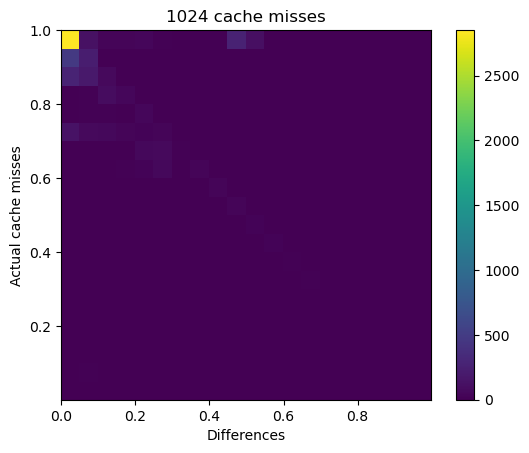

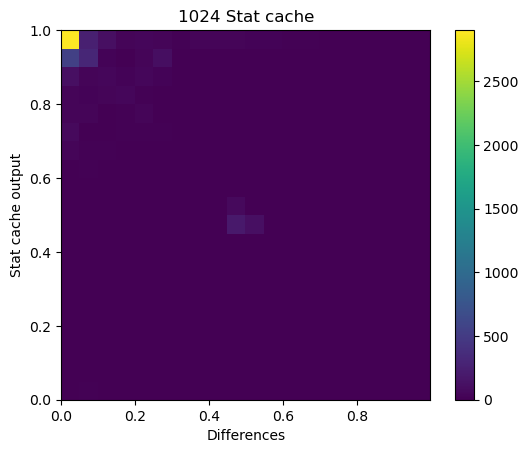

In [7]:
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'], bdf['cm_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 cache misses')
plt.xlabel('Differences')
plt.ylabel('Actual cache misses')
plt.show()
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'],  bdf['sc_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 Stat cache')
plt.ylabel('Stat cache output')
plt.xlabel('Differences')
plt.show()

0.039489982185418986


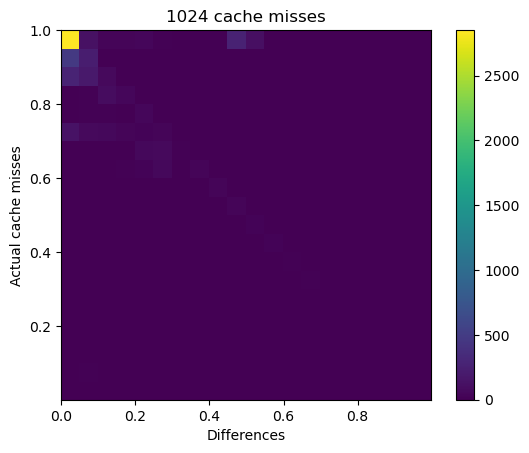

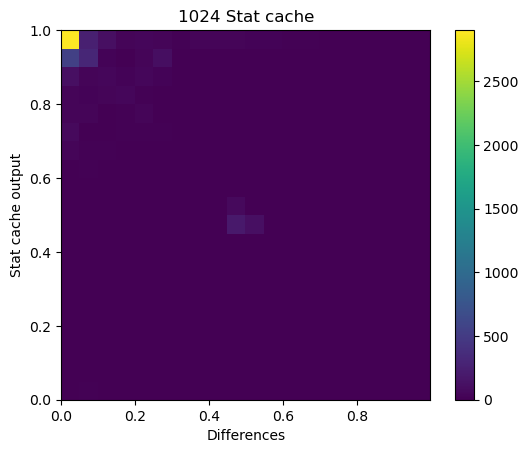

0.07974885689092122


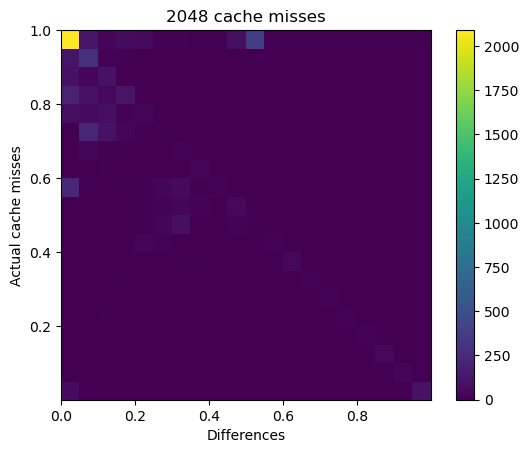

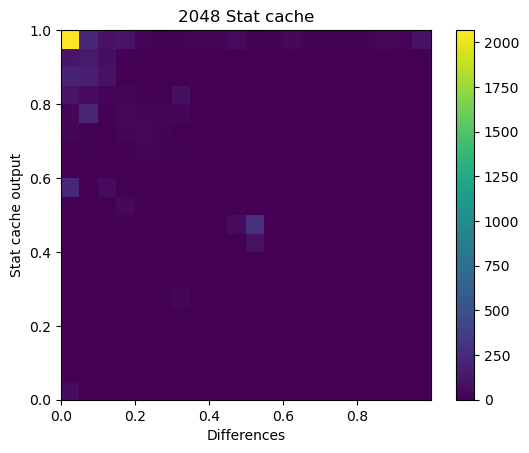

0.13735773700218162


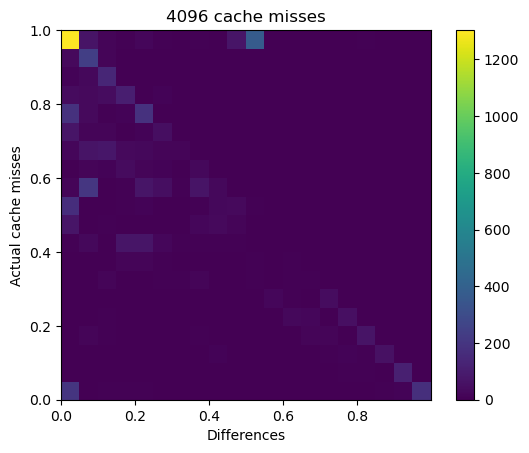

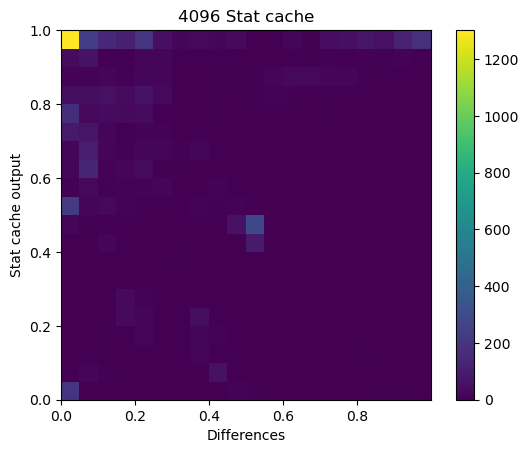

0.1395935228247368


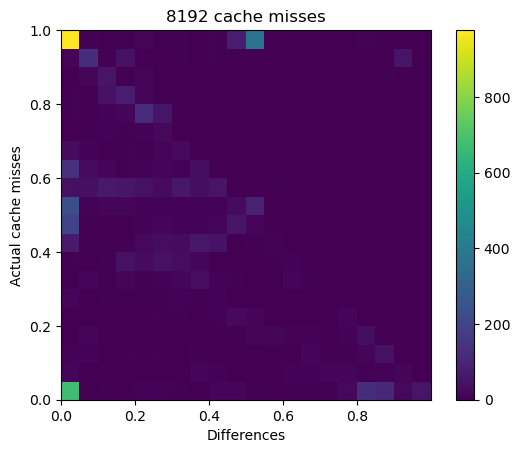

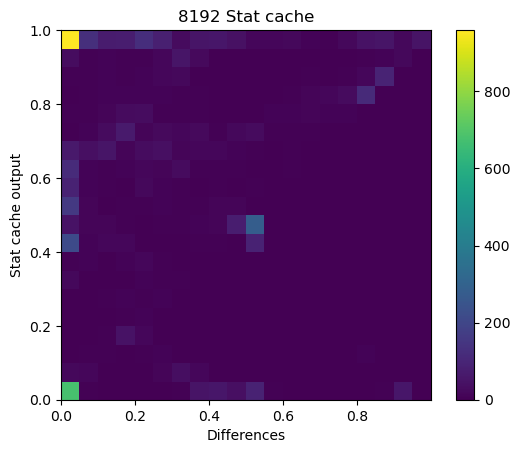

In [8]:
def plot_bdf(bdf):
    for i in ['1024','2048','4096','8192']:
        print(mean_squared_error(bdf['cm_'+i], bdf['sc_'+i]))
        heatmap, xedges, yedges = np.histogram2d(bdf['diffs_'+i], bdf['cm_'+i], bins=20)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.clf()
        plt.imshow(heatmap.T, extent=extent, origin='lower')
        plt.colorbar()
        plt.title(i+' cache misses')
        plt.xlabel('Differences')
        plt.ylabel('Actual cache misses')
        plt.show()
        heatmap, xedges, yedges = np.histogram2d(bdf['diffs_'+i],  bdf['sc_'+i], bins=20)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.clf()
        plt.imshow(heatmap.T, extent=extent, origin='lower')
        plt.colorbar()
        plt.title(i+' Stat cache')
        plt.ylabel('Stat cache output')
        plt.xlabel('Differences')
        plt.show()
plot_bdf(bdf)

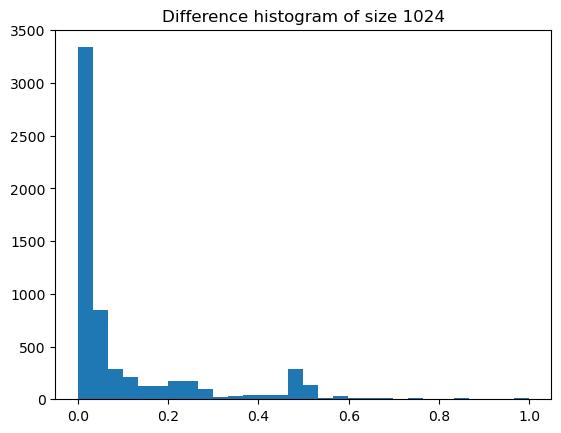

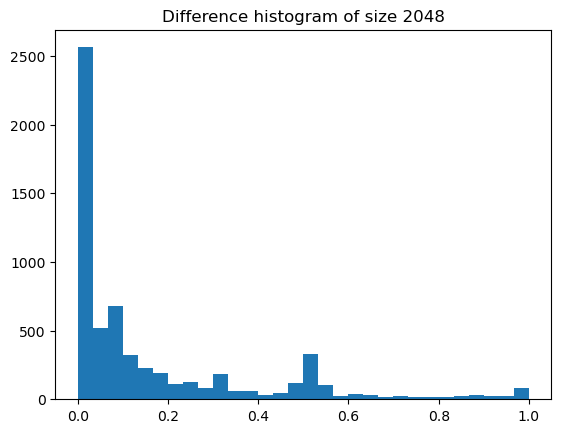

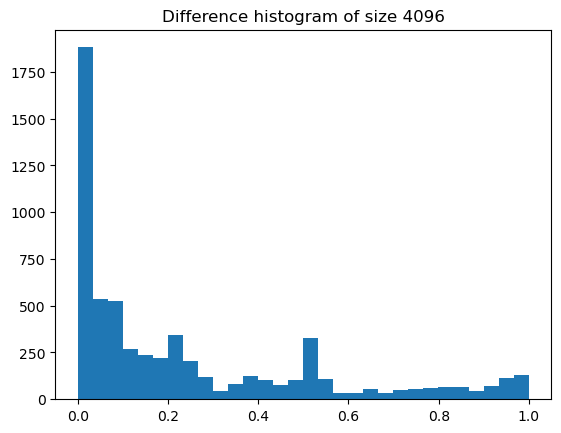

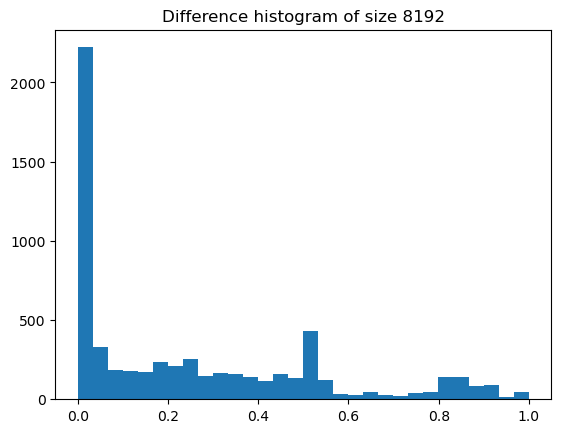

In [9]:
for i in ['1024','2048','4096','8192']:
    plt.title(f"Difference histogram of size {i}")
    plt.hist(bdf['diffs_'+i], bins =30)
    plt.show()

In [10]:
d = {}
for i in sc_out["id"]:
    ctr = 1
    while(1):
        if i[-ctr] == '_':
            break
        ctr+=1
    d[i[:-ctr]] = 1

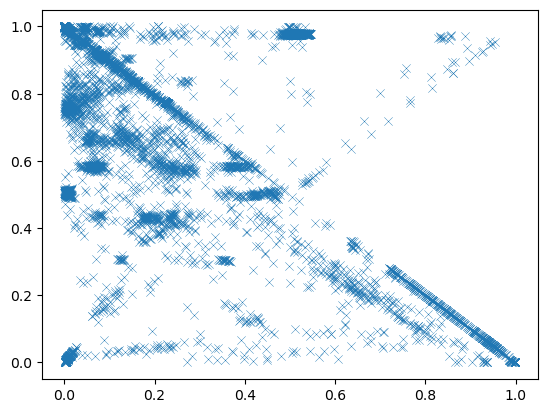

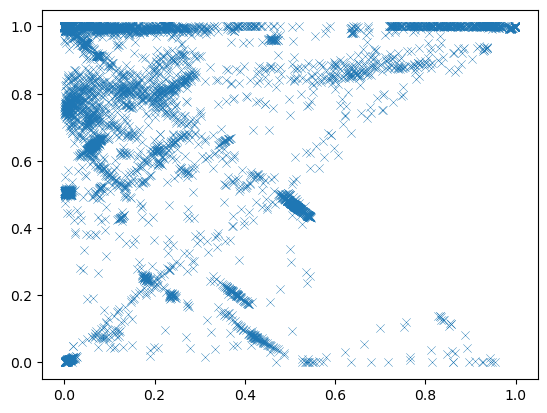

In [11]:
c = '4096'
plt.scatter(bdf['diffs_'+c], bdf['cm_'+c], marker='x', linewidths = 0.3)
plt.show()
plt.scatter(bdf['diffs_'+c], bdf['sc_'+c], marker='x', linewidths = 0.3)
plt.show()

In [12]:
columns = ["id"]
for i in ['1024','2048','4096','8192']:
    columns.append('diffs_'+i)
for i in ['1024','2048','4096','8192']:
    columns.append('cm_'+i)
    columns.append('sc_'+i)

In [13]:
# Outputs sorted by difference for some data analysis
bdf.sort_values("diffs_"+c, ascending=False)[columns].head(10)

,id,diffs_1024,diffs_2048,diffs_4096,diffs_8192,cm_1024,sc_1024,cm_2048,sc_2048,cm_4096,sc_4096,cm_8192,sc_8192
5439,623.xalancbmk_s-165B_27,0.000028,0.330588,0.999399,0.999339,0.999942,0.999970,0.669322,0.999910,0.000451,0.999850,0.000451,0.999789
5438,623.xalancbmk_s-165B_13,0.000032,0.335605,0.999351,0.999381,0.999942,0.999910,0.664275,0.999880,0.000439,0.999790,0.000409,0.999790
5553,623.xalancbmk_s-202B_693,0.006646,0.843915,0.999336,0.999304,0.993321,0.999968,0.156053,0.999968,0.000631,0.999968,0.000631,0.999935
5555,623.xalancbmk_s-202B_713,0.006387,0.824288,0.999332,0.999332,0.993583,0.999970,0.175682,0.999970,0.000638,0.999970,0.000638,0.999970
5461,623.xalancbmk_s-165B_409,0.578682,0.999382,0.999323,0.000560,0.421318,1.000000,0.000560,0.999942,0.000560,0.999883,0.000560,0.000000
5543,623.xalancbmk_s-202B_593,0.087368,0.888755,0.999318,0.999197,0.912632,1.000000,0.111245,1.000000,0.000682,1.000000,0.000682,0.999878
5440,623.xalancbmk_s-165B_41,0.000004,0.329857,0.999302,0.999246,0.999944,0.999940,0.670022,0.999879,0.000426,0.999729,0.000423,0.999668
5437,623.xalancbmk_s-165B_0,0.071359,0.385269,0.999295,0.999262,0.928511,0.999870,0.614471,0.999741,0.000381,0.999676,0.000381,0.999643
5556,623.xalancbmk_s-202B_723,0.006386,0.817636,0.999269,0.999269,0.993583,0.999969,0.182302,0.999938,0.000670,0.999938,0.000670,0.999938
5551,623.xalancbmk_s-202B_673,0.024525,0.857613,0.999224,0.999224,0.975446,0.999971,0.142328,0.999941,0.000717,0.999941,0.000717,0.999941


In [14]:
name_list_4096 = ['GemsFDTD']
l = [bool(sum(j in i for j in name_list_4096)) for i in bdf["id"]]
bdf_4096 = bdf[l]

0.0018423429635750213


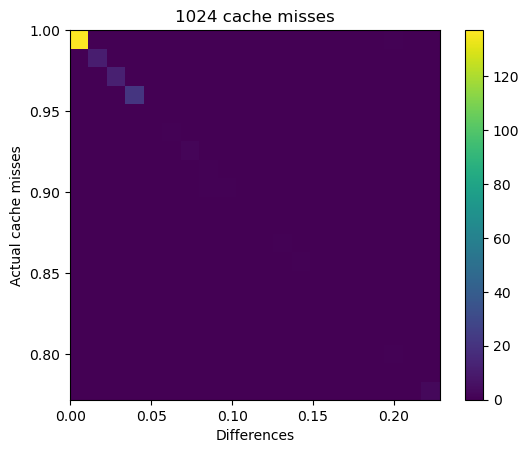

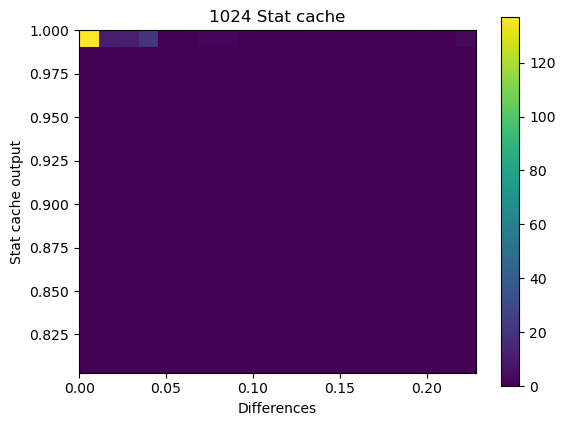

0.030961682310468645


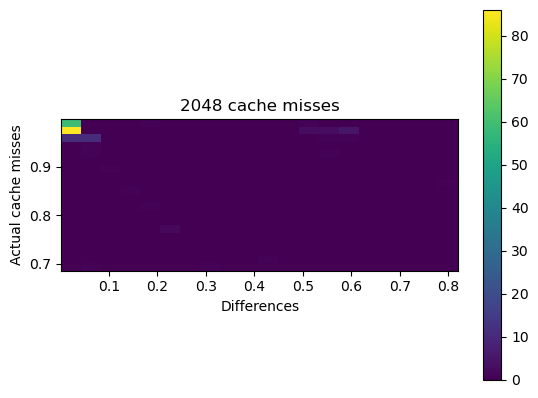

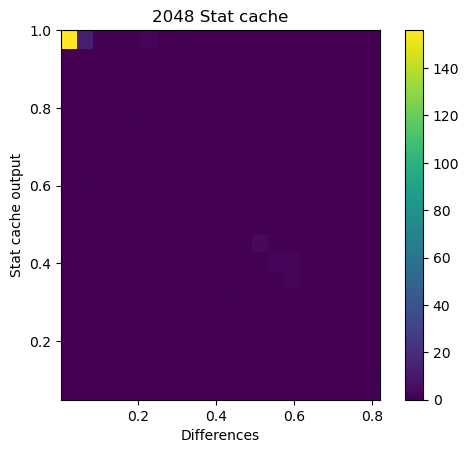

0.09234711499164507


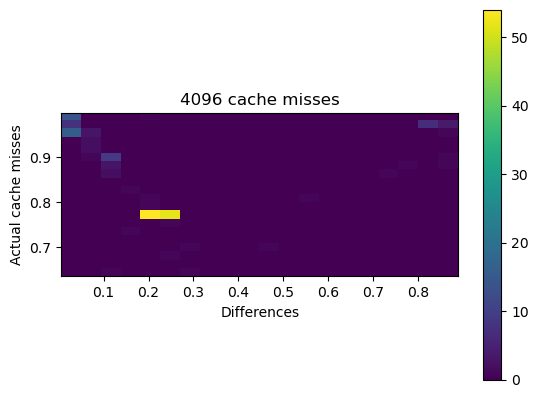

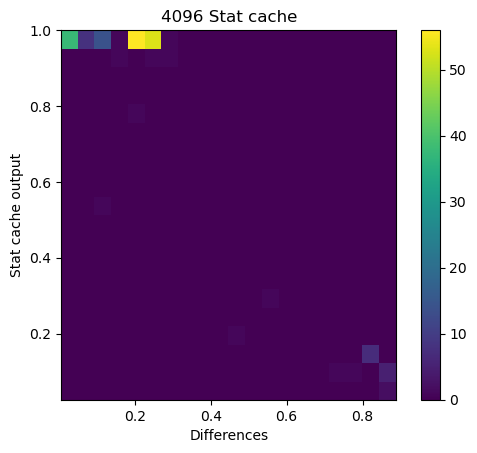

0.09977558346061163


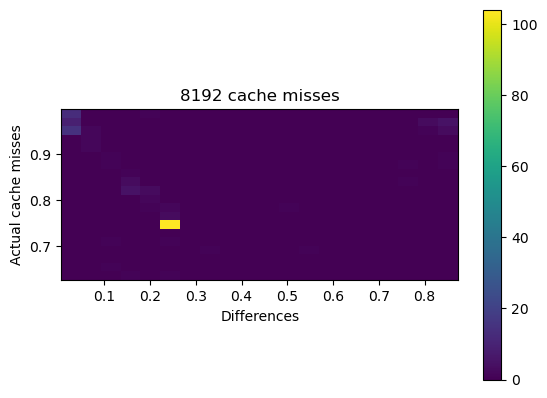

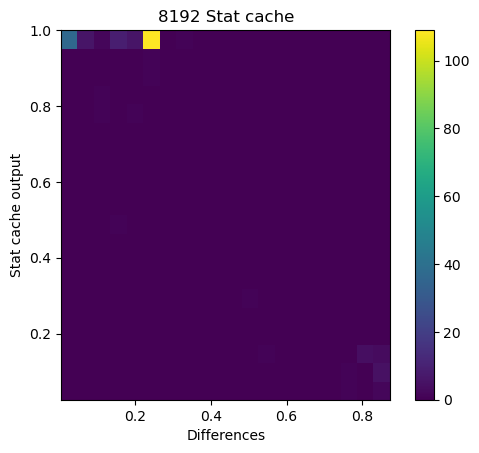

In [15]:
plot_bdf(bdf_4096)

In [16]:
bdf_4096.sort_values("diffs_1024", ascending=False)

,sc_1024,cm_1024,id,diffs_1024,sc_2048,cm_2048,diffs_2048,sc_4096,cm_4096,diffs_4096,sc_8192,cm_8192,diffs_8192
1821,1.000000,0.771707,459.GemsFDTD-765B_0,0.228293,1.000000,0.771440,0.228560,1.000000,0.771131,0.228869,0.999219,0.770668,0.228551
1748,0.999762,0.772196,459.GemsFDTD-1320B_622,0.227566,0.993217,0.685361,0.307856,0.926514,0.642790,0.283724,0.874241,0.638302,0.235939
1761,1.000000,0.775053,459.GemsFDTD-1418B_107,0.224947,0.289642,0.705624,0.415983,0.218785,0.697231,0.478446,0.131032,0.689259,0.558227
1811,0.999851,0.797526,459.GemsFDTD-1491B_496,0.202325,0.610643,0.688046,0.077403,0.540123,0.635007,0.094884,0.488140,0.625178,0.137038
1716,0.802986,0.998743,459.GemsFDTD-1211B_601,0.195758,0.802963,0.998705,0.195743,0.802939,0.998680,0.195741,0.802939,0.998675,0.195735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,1.000000,1.000000,459.GemsFDTD-1320B_703,0.000000,1.000000,0.983495,0.016505,1.000000,0.769170,0.230830,1.000000,0.750269,0.249731
1753,1.000000,1.000000,459.GemsFDTD-1320B_692,0.000000,1.000000,0.982122,0.017878,1.000000,0.772640,0.227360,1.000000,0.750288,0.249712
1752,1.000000,1.000000,459.GemsFDTD-1320B_681,0.000000,1.000000,0.979737,0.020263,1.000000,0.770312,0.229688,1.000000,0.750368,0.249632
1751,1.000000,1.000000,459.GemsFDTD-1320B_670,0.000000,1.000000,0.982947,0.017053,1.000000,0.771767,0.228233,1.000000,0.750269,0.249731
